# **Pre-processing of raw files**

In [ ]:
import os
import pandas as pd
import numpy as np
from google.colab import files
from google.colab import files
import zipfile

def replace_spaces_with_commas(file_path):
    # Read the content of the file
    with open(file_path, 'r') as file:
        content = file.read()

    # Replace all spaces with commas
    content_with_commas = content.replace(' ', ',')

    # Write the modified content back to the file
    with open(file_path, 'w') as file:
        file.write(content_with_commas)

def process_text_files(input_folder_path):
    print("Processing text files in folder:", input_folder_path)

    # Iterate over each subdirectory and its contents recursively
    for root, dirs, files in os.walk(input_folder_path):
        # Filter out text files
        txt_files = [f for f in files if f.endswith('.txt')]
        print("Text files:", txt_files)

        # Iterate over each text file
        for txt_file in txt_files:
            print("Processing text file:", txt_file)

            # Generate the full file path
            full_file_path = os.path.join(root, txt_file)
            print("Full file path:", full_file_path)

            # Replace spaces with commas in the text file
            replace_spaces_with_commas(full_file_path)

            # Read the text file into a DataFrame
            df = pd.read_csv(full_file_path, header=None, delimiter=',')

            # Define column names
            column_names = ['Date', 'Time', 'Posture', 'Probability', '', '']

            # Check if the number of columns matches the number of column names
            if len(column_names) != df.shape[1]:
                print("Length mismatch: Expected axis has", len(column_names), "elements, new values have", df.shape[1], "elements")
                continue


            df.columns = column_names

            # Remove the first row (timestamp information)
            df = df.iloc[1:]

            # Extract the date from the timestamp in the first row
            first_timestamp = pd.to_datetime(df.iloc[0, 0], format='%Y-%m-%d')
            date_str = first_timestamp.strftime('%Y-%m-%d')

            # Remove the first column (timestamp)

            df = df.drop(columns='Date')


            # Round the timestamp to the nearest second
            df['Time'] = pd.to_datetime(df['Time']).dt.round('1s').dt.strftime('%H:%M:%S')

            # Get the input folder name
            input_folder_name = os.path.basename(input_folder_path)


            # Output directory path (inside the input folder)
            output_folder_path = "Output"

            # Create the output folder if it doesn't exist
            os.makedirs(output_folder_path, exist_ok=True)

            # Save the DataFrame to a CSV file
            output_filename = f'{txt_file[:-4]}_{date_str}.csv'  # Remove the '.txt' extension
            output_file_path = os.path.join(output_folder_path, output_filename)
            df.to_csv(output_file_path, index=False)




def process_folder(input_folder):
    files = os.listdir(input_folder)

    csv_files = [f for f in files if f.endswith('.csv')]

    for csv_file in csv_files:
        full_file_path = os.path.join(input_folder, csv_file)

        # Generate the output filename based on the CSV file name
        output_filename = 'output_' + os.path.splitext(csv_file)[0] + '.csv'
        #output_file_path = os.path.join(output_folder,  output_filename)

        posture_mapping(full_file_path, output_filename)

def posture_mapping(input_file,output_file):
    df = pd.read_csv(input_file)  # Use input_file variable, not 'input_file'

    unique_values = df['Time'].unique().tolist()
    new_rows = []  # List to store new rows


    i = 0
    j = 0
    df_created = False
    new_df = None

    loop_label = "continue_label"

    while i < len(unique_values):
        value = unique_values[i]
        sitting_df = df[(df['Posture'].str.contains("Sitting")) & (df['Time'].str.contains(value))]
        standing_df = df[(df['Posture'].str.contains("Standing")) & (df['Time'].str.contains(value))]
        walking_df = df[(df['Posture'].str.contains("Walking")) & (df['Time'].str.contains(value))]

        total_sitting = sitting_df['Probability'].sum()
        total_standing = standing_df['Probability'].sum()
        total_walking = walking_df['Probability'].sum()

        sitting = sitting_df.copy()
        standing = standing_df.copy()
        walking = walking_df.copy()

        sitting_count = len(sitting)
        standing_count = len(standing)
        walking_count = len(walking)

        total_sitting = sitting['Probability'].sum()
        total_standing = standing['Probability'].sum()
        total_walking = walking['Probability'].sum()

        sitting_weight = sitting_count * total_sitting
        standing_weight = standing_count * total_standing
        walking_weight = walking_count * total_walking

        df.loc[0, "sitting_weight"] = sitting_weight
        df.loc[0, "standing_weight"] = standing_weight
        df.loc[0, "walking_weight"] = walking_weight

        max_posture = df[['sitting_weight', 'standing_weight', 'walking_weight']].idxmax(axis=1)

        posture_names = {'sitting_weight': 'sitting', 'standing_weight': 'standing', 'walking_weight': 'walking'}

        new_row = {'Time': value, 'Posture': max_posture.map(posture_names).iloc[0]}
        new_rows.append(new_row)

        # Create a new DataFrame from the list of new rows
        new_df = pd.DataFrame(new_rows)


        new_df.to_csv(output_file, index=False)
        i += 1


# Prompt the user to upload the zip file
print("Insert the zip file")
uploaded = files.upload()

# Get the uploaded zip file name
zip_file_name = list(uploaded.keys())[0]

# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall()

# Get the name of the extracted folder
extracted_folder_name = os.path.splitext(zip_file_name)[0]

# Provide the extracted folder path as input to your processing function
folder_path = os.path.join(os.getcwd(), extracted_folder_name)

# Verify the folder path
if os.path.exists(folder_path):
  process_text_files(folder_path)
  process_folder('/content/Output')
else:
  print("Folder path does not exist:", folder_path)





Insert the zip file


Saving Input2.zip to Input2.zip
Processing text files in folder: /content/Input2
Text files: []
Text files: ['red.txt']
Processing text file: red.txt
Full file path: /content/Input2/02_07_24/red.txt
Text files: ['blue.txt', 'red.txt']
Processing text file: blue.txt
Full file path: /content/Input2/03_27_24/blue.txt


<ipython-input-20-de6091b75445>:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.round('1s').dt.strftime('%H:%M:%S')
<ipython-input-20-de6091b75445>:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.round('1s').dt.strftime('%H:%M:%S')


Processing text file: red.txt
Full file path: /content/Input2/03_27_24/red.txt


<ipython-input-20-de6091b75445>:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.round('1s').dt.strftime('%H:%M:%S')


Text files: ['blue.txt', 'red.txt']
Processing text file: blue.txt
Full file path: /content/Input2/02_21_24/blue.txt
Processing text file: red.txt
Full file path: /content/Input2/02_21_24/red.txt


<ipython-input-20-de6091b75445>:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.round('1s').dt.strftime('%H:%M:%S')
<ipython-input-20-de6091b75445>:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.round('1s').dt.strftime('%H:%M:%S')


Text files: ['blue.txt', 'red.txt']
Processing text file: blue.txt
Full file path: /content/Input2/01_31_24/blue.txt


<ipython-input-20-de6091b75445>:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.round('1s').dt.strftime('%H:%M:%S')


Processing text file: red.txt
Full file path: /content/Input2/01_31_24/red.txt
Text files: ['blue.txt', 'red.txt']
Processing text file: blue.txt
Full file path: /content/Input2/02_28_24/blue.txt


<ipython-input-20-de6091b75445>:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.round('1s').dt.strftime('%H:%M:%S')
<ipython-input-20-de6091b75445>:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.round('1s').dt.strftime('%H:%M:%S')


Processing text file: red.txt
Full file path: /content/Input2/02_28_24/red.txt


<ipython-input-20-de6091b75445>:67: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time']).dt.round('1s').dt.strftime('%H:%M:%S')


# **Generating Graph for 30-s Interval**

<ipython-input-17-cfc0ca7a9708>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


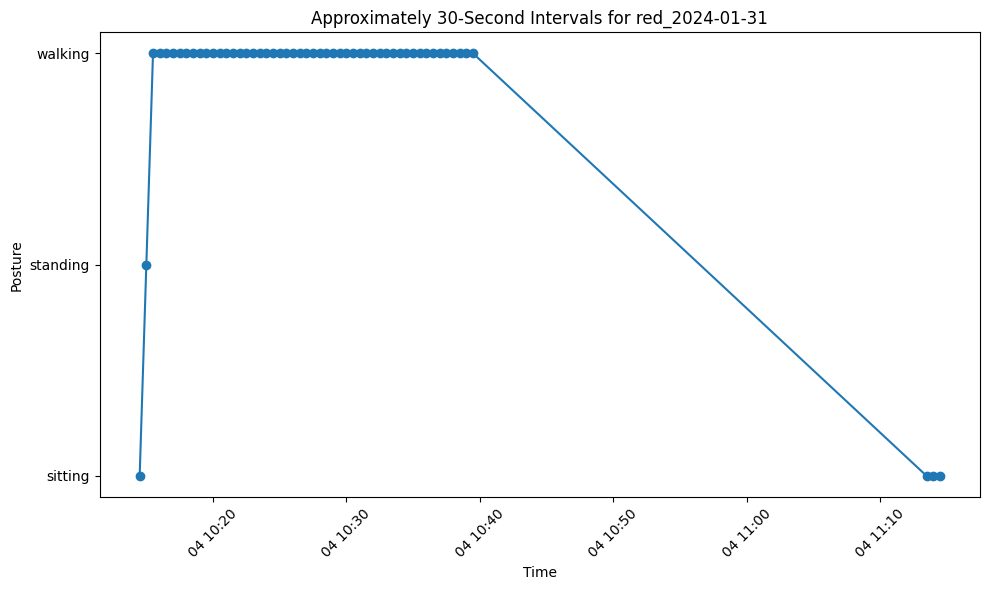

<ipython-input-17-cfc0ca7a9708>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


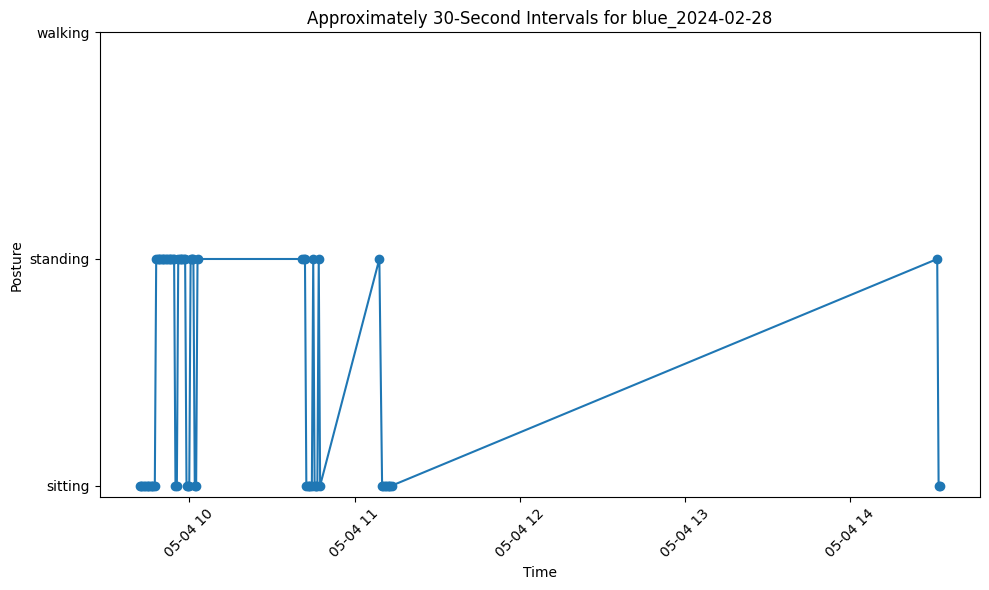

<ipython-input-17-cfc0ca7a9708>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


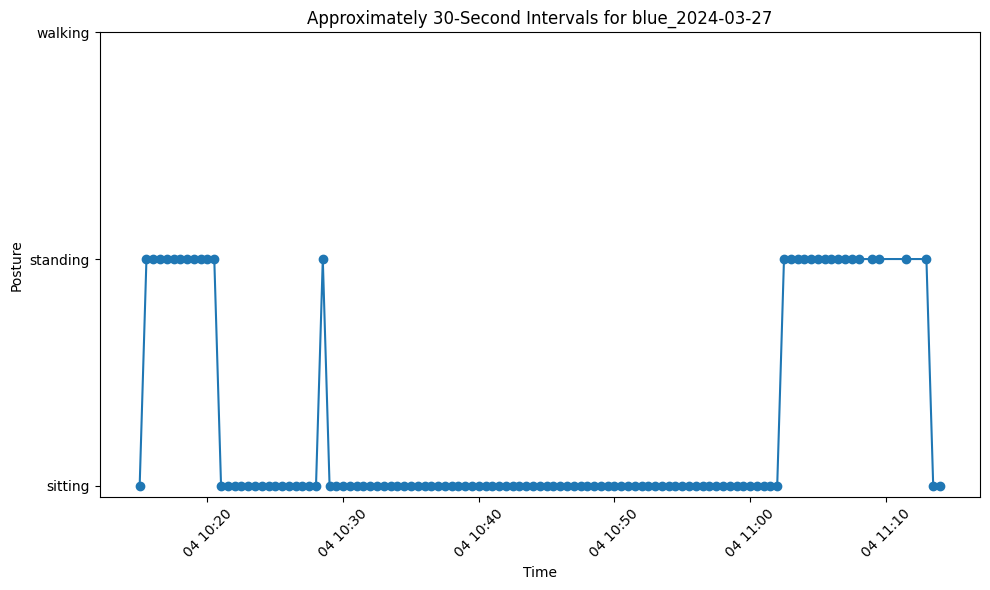

<ipython-input-17-cfc0ca7a9708>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


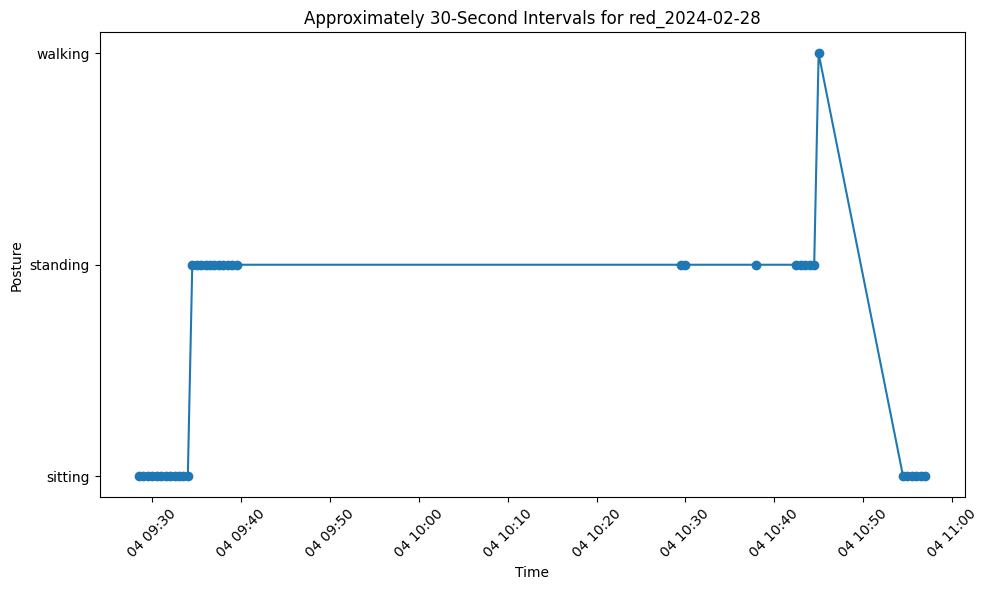

<ipython-input-17-cfc0ca7a9708>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


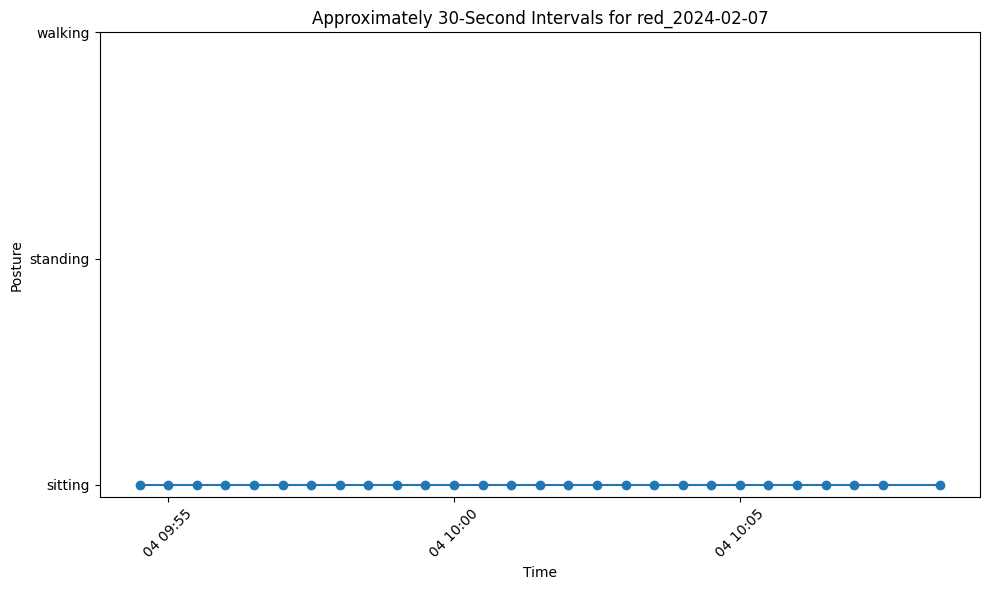

<ipython-input-17-cfc0ca7a9708>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


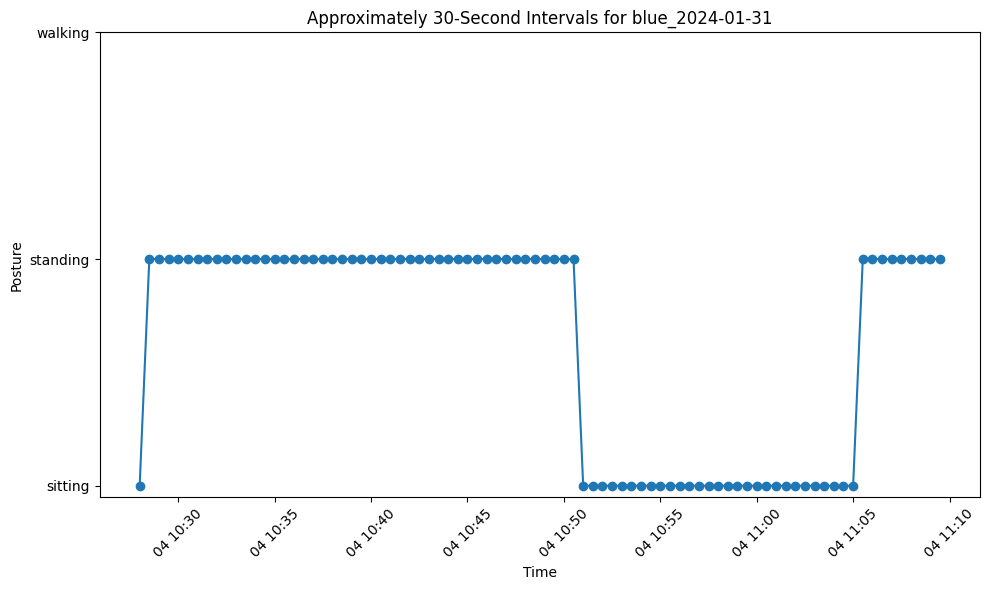

<ipython-input-17-cfc0ca7a9708>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


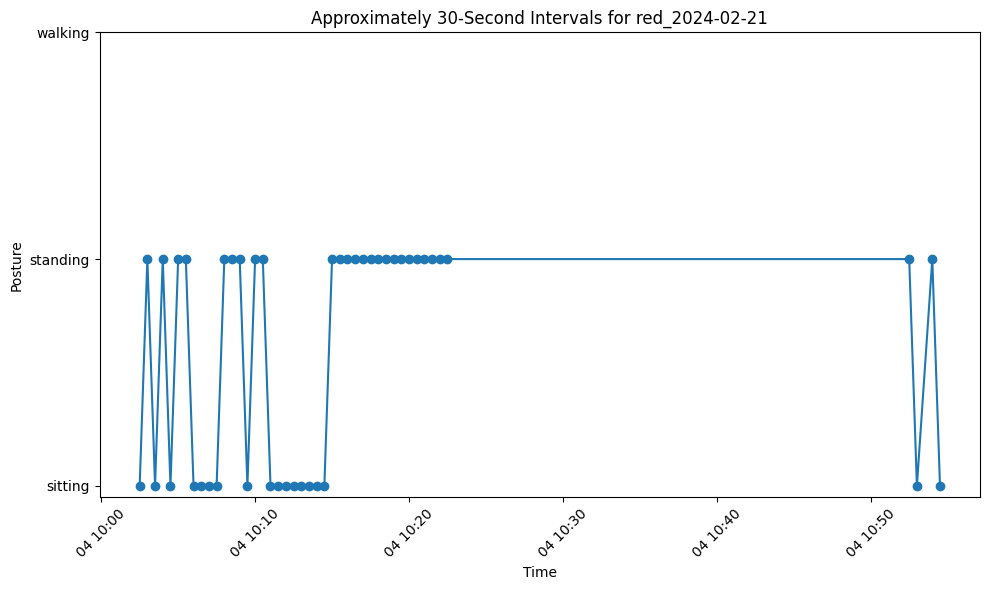

<ipython-input-17-cfc0ca7a9708>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


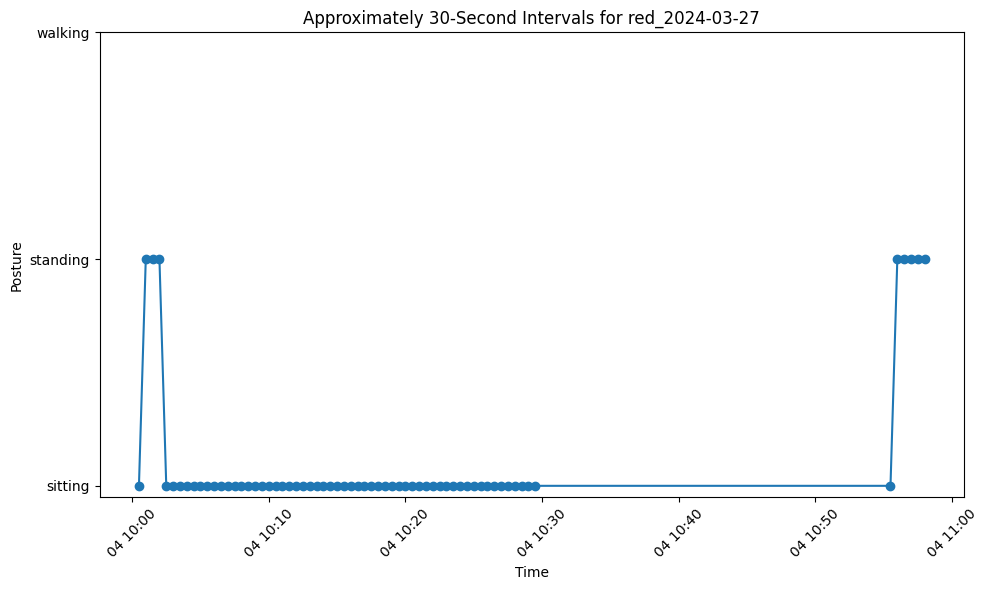

<ipython-input-17-cfc0ca7a9708>:32: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


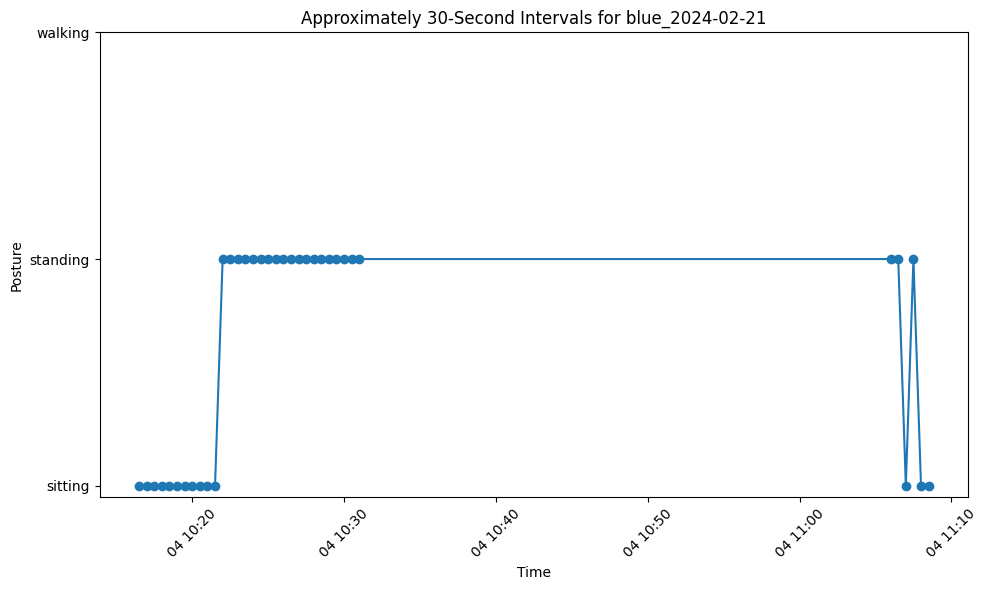

In [ ]:
import os
import matplotlib.pyplot as plt

def process_folder(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter out CSV files starting with "output_"
    csv_files = [f for f in files if f.endswith('.csv') and f.startswith('output_')]

    # Iterate over each CSV file
    for csv_file in csv_files:
        # Generate the full file path
        full_file_path = os.path.join(folder_path, csv_file)

        # Extract the filename without the extension
        filename_without_extension = os.path.splitext(csv_file)[0]

        # Extract the name after "output_" for title and output filename
        name_after_output = filename_without_extension.split('_', 1)[1]

        # Title for the plot
        plot_title = f"Approximately 30-Second Intervals for {name_after_output}"

        # Output filename for the plot
        output_filename = f"Approximately 30-Second Intervals for {name_after_output}.png"

        # Read the CSV file into a DataFrame
        df = pd.read_csv(full_file_path)

        # Convert the 'Date' column to datetime
        df['Time'] = pd.to_datetime(df['Time'])

        # Set 'Time' as the index
        df.set_index('Time', inplace=True)

        # Define a custom function to count occurrences of each posture
        def count_postures(series):
            value_counts = series.value_counts()
            if not value_counts.empty:  # Check if the Series is not empty
                return value_counts.idxmax()  # Get the most frequent posture
            else:
                return "No Data"  # Return a default value if the Series is empty

        # Downsample the DataFrame to 30-second intervals and aggregate the posture column
        downsampled_df = df.resample('30S').agg({'Posture': count_postures})

        # Filter out "No Data" values
        downsampled_df = downsampled_df[downsampled_df['Posture'] != 'No Data']

        # Define the order of categories
        posture_order = ['sitting', 'standing', 'walking']

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(downsampled_df.index, downsampled_df['Posture'], marker='o', linestyle='-')
        plt.title(plot_title)
        plt.xlabel('Time')
        plt.ylabel('Posture')

        # Set the order of categories on the y-axis
        plt.yticks(range(len(posture_order)), posture_order)

        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

        plt.tight_layout()
        plt.savefig(output_filename)
        plt.show()

        # Extract hour, minute, and second values from the 'Time' index
        downsampled_df['Time'] = downsampled_df.index.strftime('%H:%M:%S')

        # Save the downsampled DataFrame to a CSV file without the date part
        downsampled_df[['Time', 'Posture']].to_csv(f"{name_after_output}.csv", index=False)

# Example usage:
folder_path = '/content'  # Replace with the path to your folder containing CSV files
process_folder(folder_path)

# **Generating Graph for 60-s Interval**

<ipython-input-19-784f781f641c>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


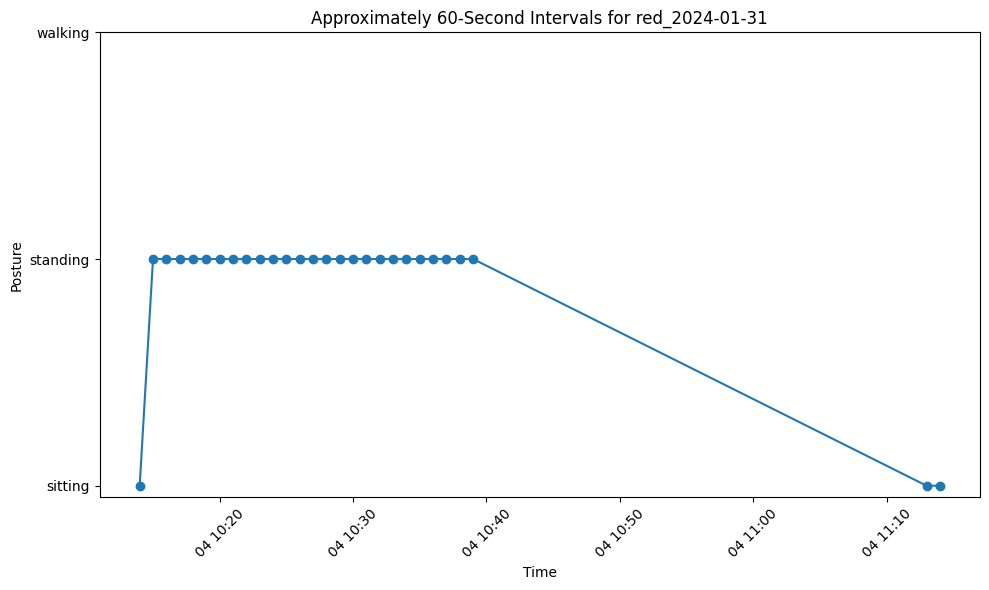

<ipython-input-19-784f781f641c>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


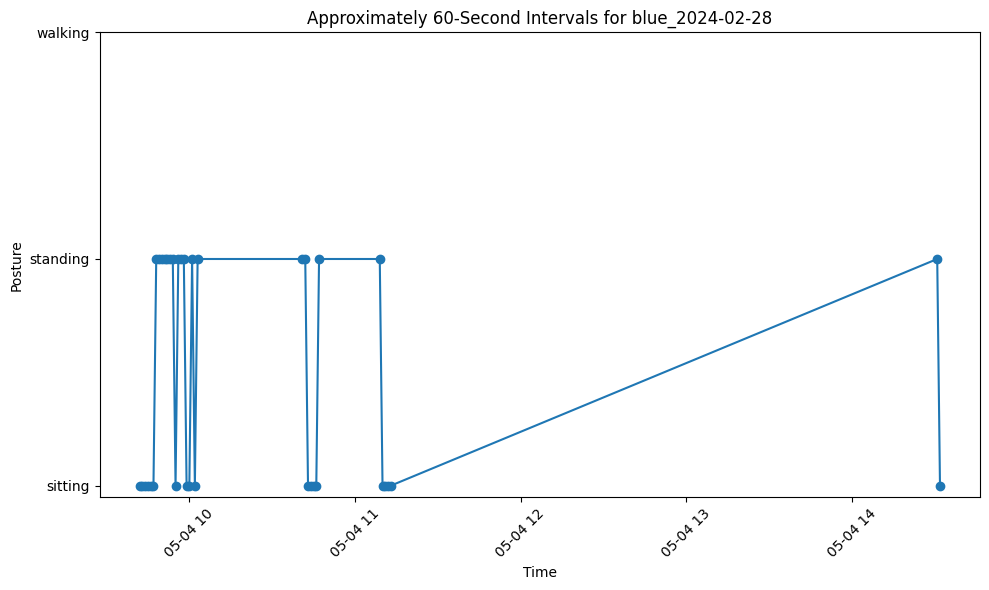

<ipython-input-19-784f781f641c>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


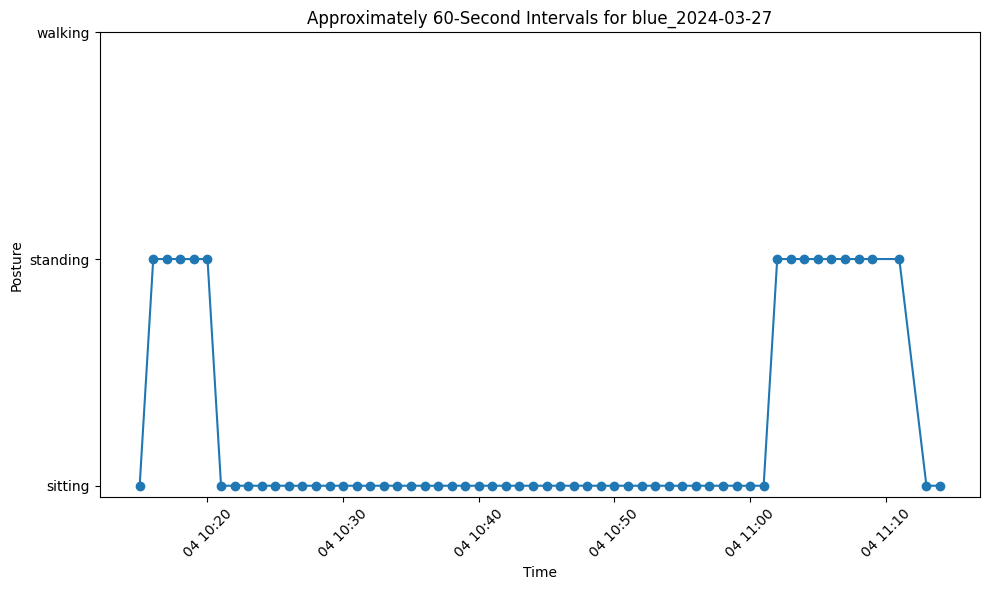

<ipython-input-19-784f781f641c>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


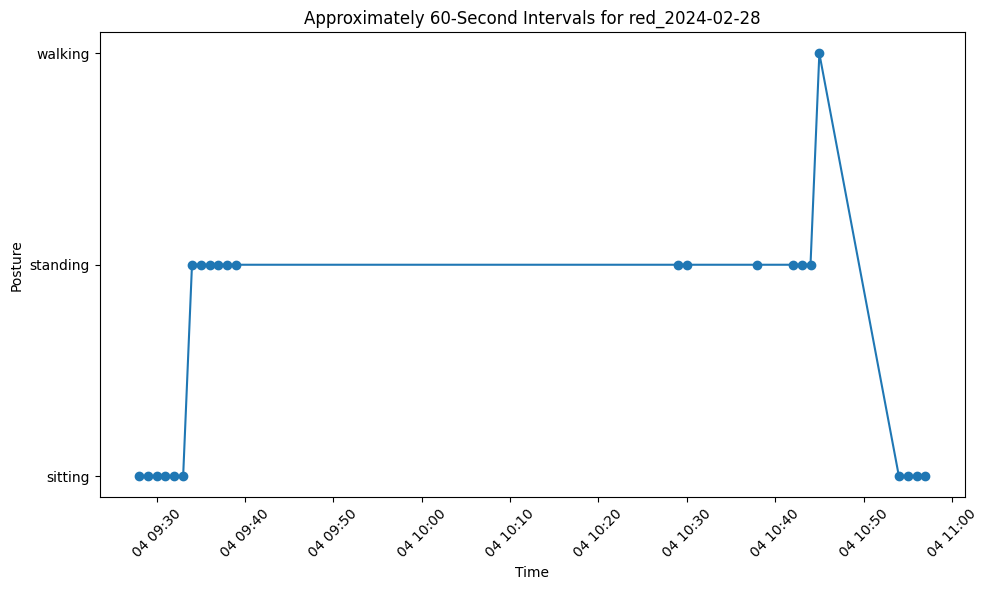

<ipython-input-19-784f781f641c>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


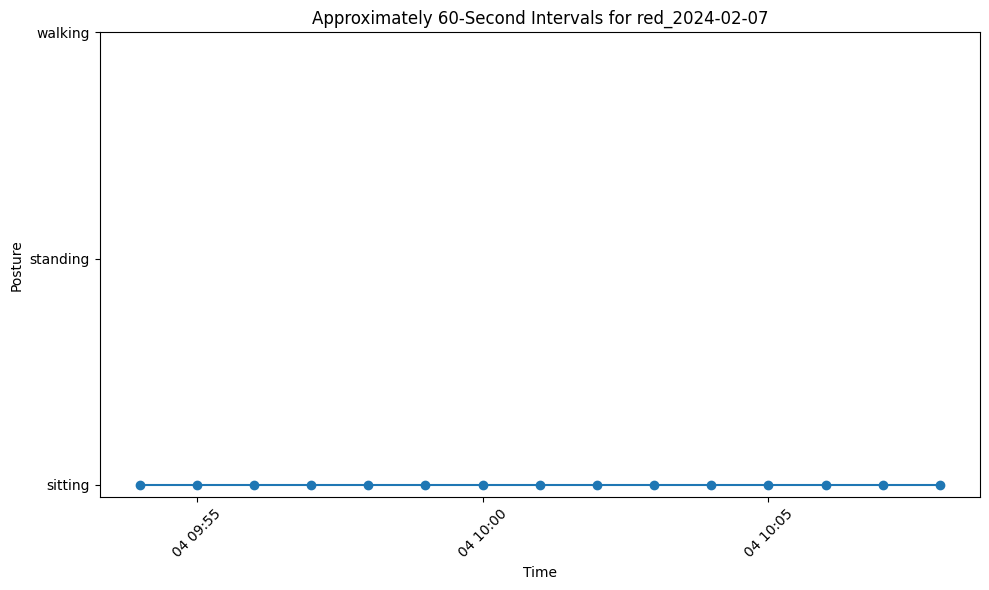

<ipython-input-19-784f781f641c>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


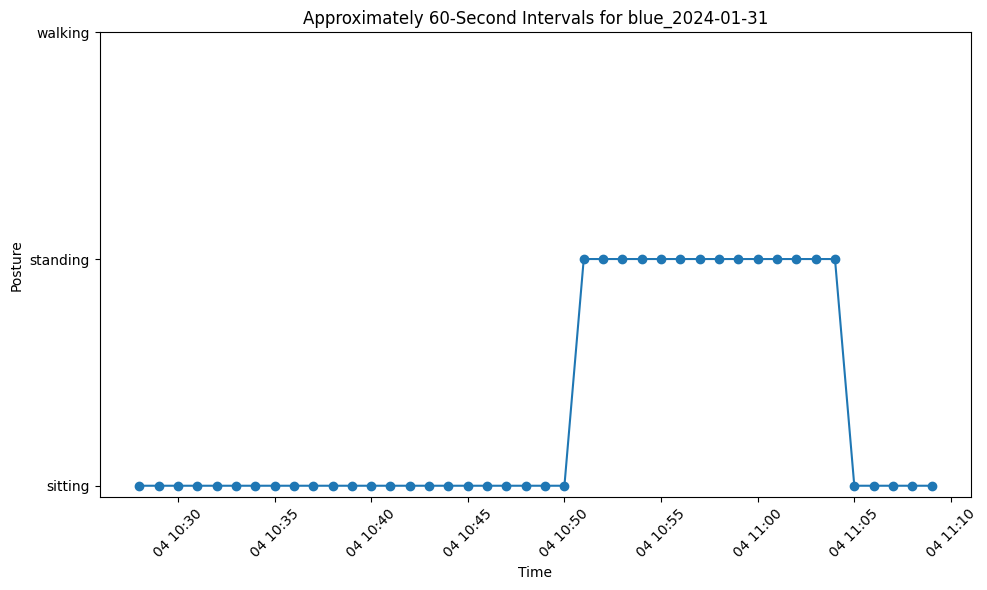

<ipython-input-19-784f781f641c>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


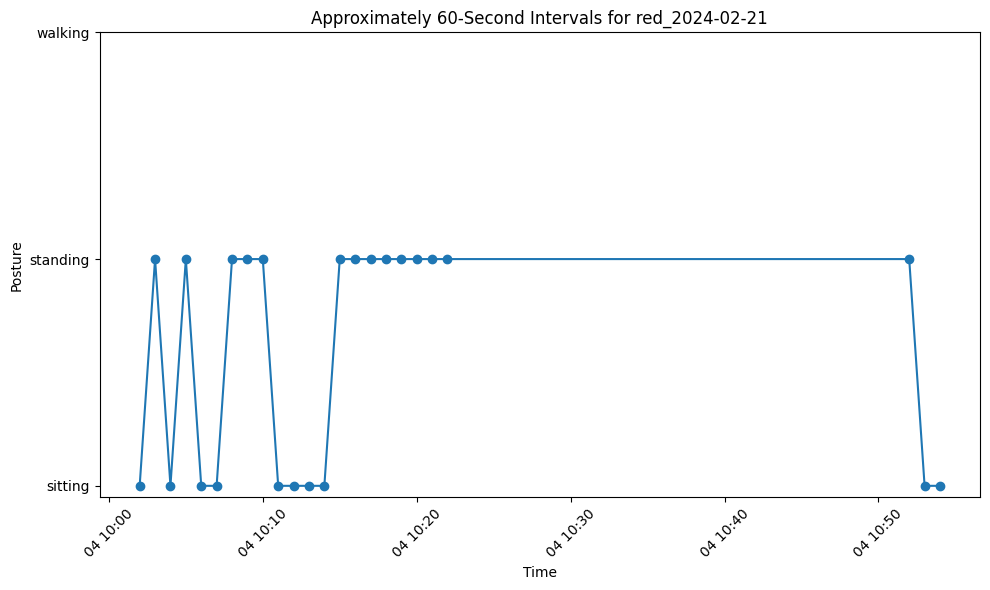

<ipython-input-19-784f781f641c>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


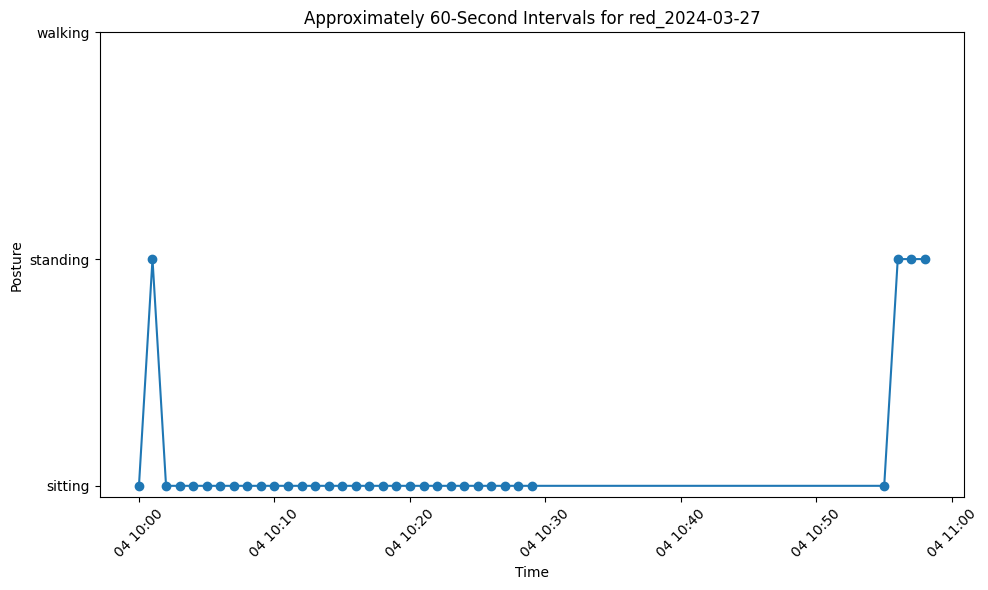

<ipython-input-19-784f781f641c>:33: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Time'] = pd.to_datetime(df['Time'])


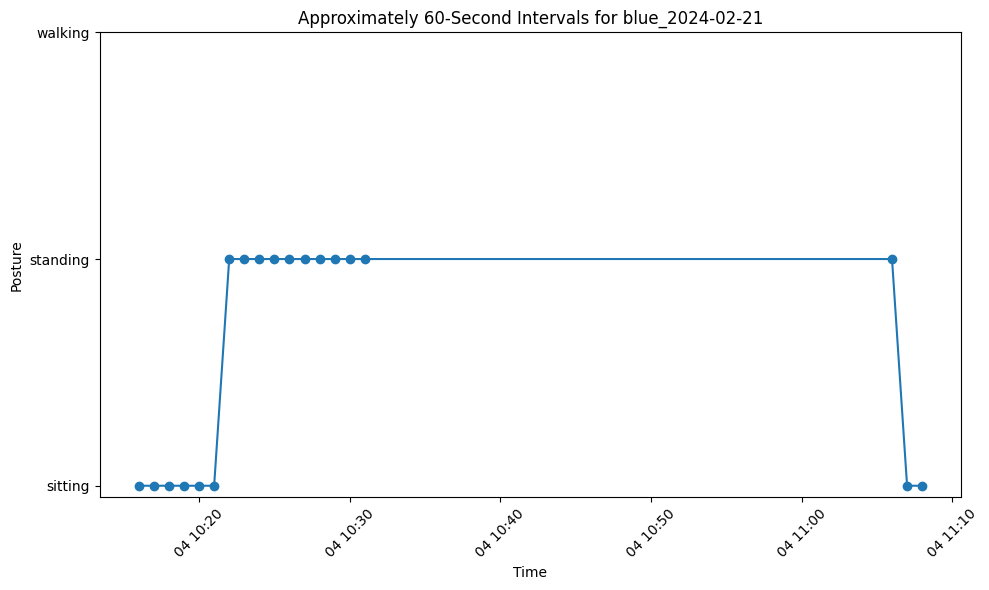

In [ ]:
import os
import matplotlib.pyplot as plt


def process_folder(folder_path):
    # List all files in the folder
    files = os.listdir(folder_path)

    # Filter out CSV files starting with "output_"
    csv_files = [f for f in files if f.endswith('.csv') and f.startswith('output_')]

    # Iterate over each CSV file
    for csv_file in csv_files:
        # Generate the full file path
        full_file_path = os.path.join(folder_path, csv_file)

        # Extract the filename without the extension
        filename_without_extension = os.path.splitext(csv_file)[0]

        # Extract the name after "output_" for title and output filename
        name_after_output = filename_without_extension.split('_', 1)[1]

        # Title for the plot
        plot_title = f"Approximately 60-Second Intervals for {name_after_output}"

        # Output filename for the plot
        output_filename = f"Approximately 60-Second Intervals for {name_after_output}.png"

        # Read the CSV file into a DataFrame
        df = pd.read_csv(full_file_path)

        # Convert the 'Date' column to datetime
        df['Time'] = pd.to_datetime(df['Time'])

        # Set 'Time' as the index
        df.set_index('Time', inplace=True)

        # Define a custom function to count occurrences of each posture
        def count_postures(series):
            value_counts = series.value_counts()
            if not value_counts.empty:  # Check if the Series is not empty
                return value_counts.idxmax()  # Get the most frequent posture
            else:
                return "No Data"  # Return a default value if the Series is empty

        # Downsample the DataFrame to 30-second intervals and aggregate the posture column
        downsampled_df = df.resample('60S').agg({'Posture': count_postures})

        # Filter out "No Data" values
        downsampled_df = downsampled_df[downsampled_df['Posture'] != 'No Data']

        # Define the order of categories
        posture_order = ['sitting', 'standing', 'walking']

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.plot(downsampled_df.index, downsampled_df['Posture'], marker='o', linestyle='-')
        plt.title(plot_title)
        plt.xlabel('Time')
        plt.ylabel('Posture')

        # Set the order of categories on the y-axis
        plt.yticks(range(len(posture_order)), posture_order)

        plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

        plt.tight_layout()
        plt.savefig(output_filename)
        plt.show()

        # Extract hour, minute, and second values from the 'Time' index
        downsampled_df['Time'] = downsampled_df.index.strftime('%H:%M:%S')

        # Save the downsampled DataFrame to a CSV file without the date part
        downsampled_df[['Time', 'Posture']].to_csv(f"{name_after_output}.csv", index=False)

# Example usage:
folder_path = '/content'  # Replace with the path to your folder containing CSV files
process_folder(folder_path)